# Attempt 1

We are solving the following system of equations:
$$\frac{\Omega_i^k - \Omega^{k-1}_i}{\tau} - \frac{v^{k-1}\xi_i}{\gamma^{k-1}} \frac{\Omega_{i+1}^k - \Omega^{k}_{i-1}}{2h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3(\Omega_{i+1}^k - \Omega^{k}_{i})  - \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 (\Omega_{i}^k - \Omega^{k}_{i-1})\right) = 0$$

$$\Omega_0^k = 0$$
$$\Omega_{N-1}^k = 1$$

$$  v^k = (\Omega_{N-2}^k)^2 \frac{ \Omega_{N-3}^k}{2\gamma^{k-1} h}   $$

Let's combine the terms

$$ \Omega_{i+1}^k \left( - \frac{v^{k-1}\xi_i}{2\gamma^{k-1} h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3 \right)  + \Omega_i^k \left( \frac{1}{\tau} +  \frac{1}{(\gamma^{k-1} h)^2}\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3 - \frac{1}{(\gamma^{k-1} h)^2}\left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 \right) + \Omega_{i-1}^k \left( \frac{v^{k-1}\xi_i}{2\gamma^{k-1} h} -  \frac{1}{(\gamma^{k-1} h)^2} \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 \right) = \frac{\Omega_i^{k-1}}{\tau}$$

So we'll need to solve the system of equations

$$ A(\Omega^{k-1}) \Omega^k = f(\Omega^{k-1})$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [98]:
N = 100
xi = np.linspace(0,1,N)
h = 1/(N-1)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
g = 4                             # initial gamma
v0 = W0[N-2]**2*W0[N-3]/g/2/h     # initial velocity
t = 10**(-5)                      # time step

Text(0, 0.5, 'xi')

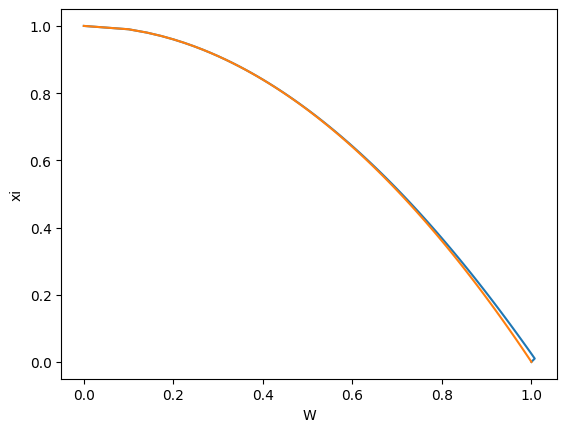

In [99]:
v_prev = v0.copy()
W_prev = W0.copy()
eps = 1
eps_v = 1

n_t = 10**5        # number of time steps
# psi0 = np.empty(n_t+1)
# psi0[0] = - ((W0[0] + W0[1])/2)**3/g*(-W0[0] + W0[1])/h
# t0 = 10**(-3)
# time = [t0]

for j in range(n_t):                # time loop
    # gs.append(g)
    # ts.append(j*t)
    while(eps_v > 10**(-2)):        # loop to approximate the velocity v
        while(eps > 10**(-2)):      # loop to approximate the opening omega
            # upper diagonal
            a1 = np.zeros(N-1)
            a1[1:-1] = - v_prev/g*xi[1:-2]/2/h - 1/(g*h)**2*((W_prev[1:-2] + W_prev[2:-1])/2)**3

            # main diagonal
            a0 = np.ones(N)
            a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3

            # lower diagonal
            a_1 = np.zeros(N-1)
            a_1[:-1] = v_prev/g*xi[1:-1]/2/h - 1/(g*h)**2*((W_prev[:-2] + W_prev[1:-1])/2)**3

            # right hand side
            f = np.zeros(N)
            f[0] = 1
            f[-1] = 0
            f[1:-1] = W_prev[1:-1]/t

            # making matrix and solving the system
            k = [a_1,a0, a1]
            offset = [-1,0,1]
            A = diags(k,offset, format = 'csr')
            W = spsolve(A, f)

            # error of solution
            eps = np.sqrt(((W - W_prev)**2).mean())
            
            W_prev = W.copy()

        # getting new velocity
        v = W_prev[N-2]**2*W_prev[N-3]/g/2/h
        eps_v = np.abs(v - v_prev)
        v_prev = v.copy()

    # getting new gamma
    g = g + v_prev*t
    # time.append(time[j] + t)
    # psi0[j+1] = - ((W[0] + W[1])/2)**3/g*(-W[0] + W[1])/h

plt.figure()
plt.plot(W_prev, xi)
plt.plot(W0, xi)
plt.xlabel('W')
plt.ylabel('xi')

# Attempt 1.1

In [319]:
N = 10
xi = np.linspace(0,1,N)
h = 1/(N-1)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
g = 4                             # initial gamma
v0 = W0[N-2]**2*W0[N-3]/g/2/h     # initial velocity
t = 10**(-7)                      # time step

[ 0.         -8.78063418 -6.81093147 -5.09107666 -3.62100476 -2.40059926
 -1.4296195  -0.7074292  -0.22980474  0.        ]
[ 0.00000000e+00 -1.57949663e+03 -5.53812909e+04 -2.05935912e+04
 -6.71276235e+03 -1.84456604e+03 -4.02496605e+02 -6.30515414e+01
 -5.69382229e+00  0.00000000e+00]
[ 0.00000000e+00 -6.29769985e+18  2.99000276e+18 -2.09201383e+19
 -3.50421380e+17 -3.39471808e+15 -1.62578158e+13 -3.05350048e+10
 -1.56204073e+07  0.00000000e+00]
[ 0.00000000e+00 -7.82715424e+74 -8.72941074e+76  5.98632348e+76
 -1.29536061e+77 -9.91711619e+69 -8.56622846e+61 -4.45434149e+52
 -5.51258711e+41  0.00000000e+00]
[ 0.00000000e+000 -3.74053111e+307 -3.61600637e+307 -4.08945511e+307
  1.63259593e+308 -1.78171376e+308 -6.12091954e+279 -3.40748271e+247
 -2.49120280e+210  0.00000000e+000]
[  0.  nan  nan -inf  nan  nan  nan  nan  nan   0.]


C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:50: RuntimeWarning: overflow encountered in square
  eps = np.sqrt(((W - W_prev)**2).mean())
C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:25: RuntimeWarning: overflow encountered in power
  a1[1:-1] = - v_prev/g*xi[1:-2]/2/h - 1/(g*h)**2*((W_prev[1:-2] + W_prev[2:-1])/2)**3
C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:28: RuntimeWarning: overflow encountered in power
  a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3
C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:28: RuntimeWarning: invalid value encountered in subtract
  a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3
C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:31: RuntimeWarning: overflow encountered in power
  a_1[:-1] = v_prev/g*xi[1:-1]/2/h - 1/(g*h)**2*((W_prev[:-2] + W_

Text(0, 0.5, 'xi')

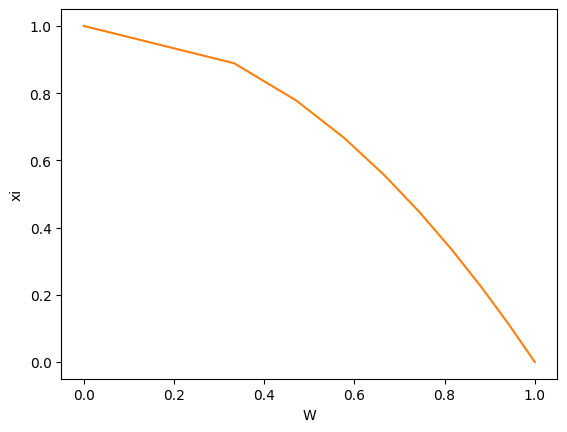

In [326]:
v_prev = v0.copy()
W_prev = W0.copy()
eps = 1
eps_v = 1
errs = []

n_t = 10**5        # number of time steps
# psi0 = np.empty(n_t+1)
# psi0[0] = - ((W0[0] + W0[1])/2)**3/g*(-W0[0] + W0[1])/h
# t0 = 10**(-3)
# time = [t0]

# for j in range(n_t):                # time loop
    # gs.append(g)
    # ts.append(j*t)
    # while(eps_v > 10**(-2)):        # loop to approximate the velocity v
        # while(eps > 10**(-2)):      # loop to approximate the opening omega
            # upper diagonal
i = 0
max_iter = 100
while eps > 10**(-2):
    # print(i)
    i += 1
    a1 = np.zeros(N-1)
    a1[1:-1] = - v_prev/g*xi[1:-2]/2/h - 1/(g*h)**2*((W_prev[1:-2] + W_prev[2:-1])/2)**3
    # main diagonal
    a0 = np.ones(N)
    a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3
    # lower diagonal
    a_1 = np.zeros(N-1)
    a_1[:-1] = v_prev/g*xi[1:-1]/2/h - 1/(g*h)**2*((W_prev[:-2] + W_prev[1:-1])/2)**3
    # right hand side
    f = np.zeros(N)
    f[0] = 1
    f[-1] = 0
    f[1:-1] = W_prev[1:-1]/t
    
    # making matrix and solving the system
    k = [a_1,a0, a1]
    offset = [-1,0,1]
    A = diags(k,offset, format = 'csr')
    # if i == 1:
        # W = spsolve(A, f)
    # else:
        # W = W_prev - A@W_prev + f
    # error of solution
    # eps = np.sqrt(((W - W_prev)**2).mean())
    # A_inv = np.linalg.inv(A)
    W = W_prev -  A@W_prev + f
    eps = np.sqrt(((W - W_prev)**2).mean())
    errs.append(eps)
    print(A@W_prev - f)
    W_prev = W.copy()
    if i == max_iter:
        break

# print(A@W_prev - f)
# print(A@W - f)
    
# W_prev = W.copy()
# # getting new velocity
# v = W_prev[N-2]**2*W_prev[N-3]/g/2/h
# eps_v = np.abs(v - v_prev)
# v_prev = v.copy()

    # getting new gamma
    # g = g + v_prev*t
    # time.append(time[j] + t)
    # psi0[j+1] = - ((W[0] + W[1])/2)**3/g*(-W[0] + W[1])/h

plt.figure()
plt.plot(W_prev, xi)
plt.plot(W0, xi)
plt.xlabel('W')
plt.ylabel('xi')

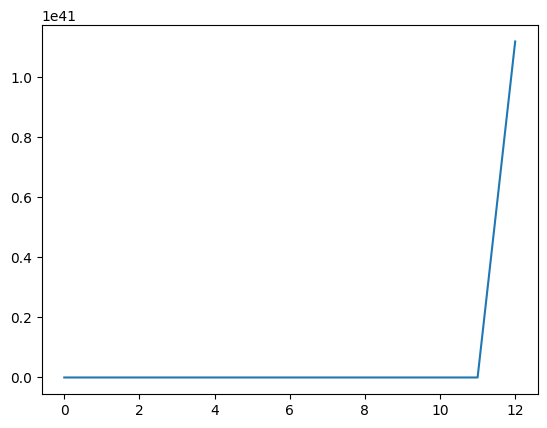

In [324]:
plt.plot(errs)

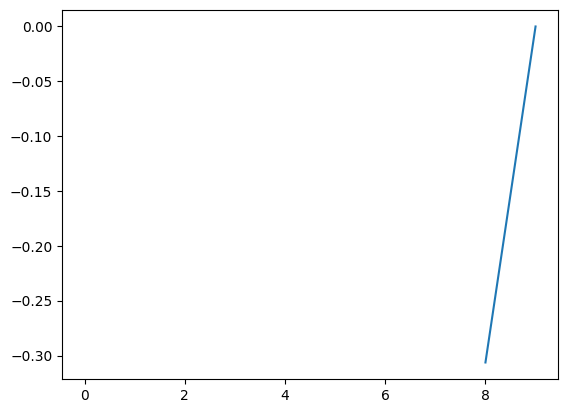

In [325]:
plt.plot(W - W0)

# Attempt 2
We are solving the following system of equations:
$$\frac{\Omega_i^k - \Omega^{k-1}_i}{\tau} - \frac{v^{k-1}\xi_i}{\gamma^{k-1}} \frac{\Omega_{i+1}^k - \Omega^{k}_{i-1}}{2h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3(\Omega_{i+1}^k - \Omega^{k}_{i})  - \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 (\Omega_{i}^k - \Omega^{k}_{i-1})\right) = 0$$

$$\Omega_{-1}^k = 0$$
$$\Omega_{N}^k = 1$$

$$ v^k = (\Omega_{N-1}^k)^2 \frac{ \Omega_{N-2}^k}{2\gamma^{k-1} h}  $$

Let's introduce new variable $\Delta \Omega_i = \Omega_i^k -  \Omega_i^{k-1} $ and rewrite equations. Let $\Omega_i^0 = \Omega_i^{k-1}$.

$$ \Delta \Omega_i - \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Delta \Omega_{i+1} - \Delta \Omega_{i-1}) - \frac{\tau}{(\gamma^{k-1} h)^2} \left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Delta\Omega_{i+1} -\Delta \Omega_{i}) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Delta\Omega_{i} - \Delta\Omega_{i-1})  \right) =  \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Omega_{i+1}^0 - \Omega_{i-1}^0) + \frac{\tau}{(\gamma^{k-1} h)^2}\left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Omega_{i+1}^0 - \Omega_{i}^0) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Omega_{i}^0 - \Omega_{i-1}^0) \right)$$

Let's combine the terms

$$ \Delta \Omega_{i+1} \left( - \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} - \frac{\tau}{(\gamma^{k-1} h)^2} \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 \right)  + \Delta \Omega_i \left( 1 +  \frac{\tau}{(\gamma^{k-1} h)^2}\left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 - \frac{\tau}{(\gamma^{k-1} h)^2}\left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 \right) + \Delta \Omega_{i-1} \left( \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} -  \frac{1}{(\gamma^{k-1} h)^2} \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 \right) = \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Omega_{i+1}^0 - \Omega_{i-1}^0) + \frac{\tau}{(\gamma^{k-1} h)^2}\left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Omega_{i+1}^0 - \Omega_{i}^0) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Omega_{i}^0 - \Omega_{i-1}^0) \right)$$

So we'll need to solve the system of equations

$$ A(\Omega^0) \Delta \Omega = f(\Omega^0)$$

In [331]:
# k_{i+1/2} = ((omega(i+1) + omega(i))/2)^3
def K(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    return k**3

# psi_{k+1/2}
# def psi(w, g):
#     psi = np.empty(w.shape[0] + 1)
#     k = K(w)
#     psi[0] = - k[0]*(w[0] - 1)/(h*g)
#     psi[-1] = - k[-1]*w[-1]/(h*g)
#     psi[1:-1] = - k[1:-1]*(w[2:] - w[1:-1])/(h*g)
#     return psi

In [334]:
N = 10
h = 1/(N+1)
xi = np.linspace(h, 1 - h, N)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
tau = 10**(-4)                    # time step
g = 4                             # initial gamma
v0 = W0[-1]**2*W0[-2]/g/2/h       # initial velocity

# useful coeffitients
a = tau/(g*h)**2
b = tau*v0/(2*g*h)

W_prev = W0.copy()

errs = []
err = 1

# for j in range(nt)            # time loop
for i in range(1000):         # solving nonlinear equation for given time step

    # making matrix A
    
    k = K(W_prev)

    k0 = 1 + a*(k[1:] - k[:-1])
    k1 = -b*xi[:-1] - a*k[1:-1]
    k_1 = b*xi[1:] - a*k[1:-1]

    A = diags([k_1, k0, k1],[-1,0,1], format = 'csr')

    # right-hand side
    
    f = np.empty(N)
    f[0] = b*xi[0]*(W_prev[1] - 1) + a*(k[1]*(W_prev[1] - W0[0]) - k[0]*(W_prev[0] - 1))
    f[1:-1] = b*xi[1:-1]*(W_prev[2:] - W_prev[:-2]) + a*(k[2:-1]*(W_prev[2:] - W_prev[1:-1]) - k[1:-2]*(W_prev[1:-1] - W_prev[:-2]))
    f[-1] = b*xi[-1]*(-W_prev[-1]) + a*(k[-1]*(-W_prev[-1]) - k[-2]*(W_prev[-1] - W_prev[-2]))

    # solving system
    dW = spsolve(A, f)

    # new solution
    W_next = W_prev + dW

    err = np.sqrt(((W_next - W_prev)**2).mean())
    errs.append(err)

    if err > 1:
        print('error: ', err)
        break

    W_prev = W_next.copy()

# print('a: ', a)
# print('b: ', b)

[1.         0.95633607 0.90750641 0.85572849 0.80056378 0.74128362
 0.67680703 0.60546808 0.52445712 0.42828503 0.30329581 0.        ]


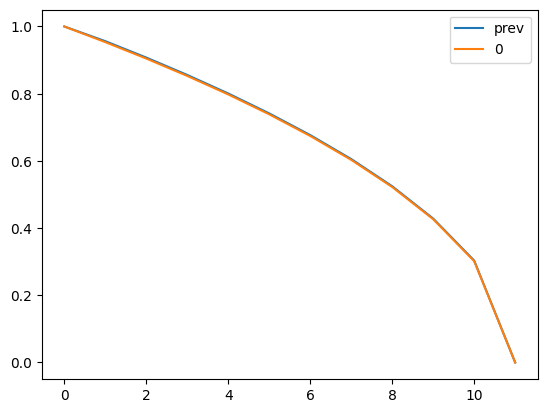

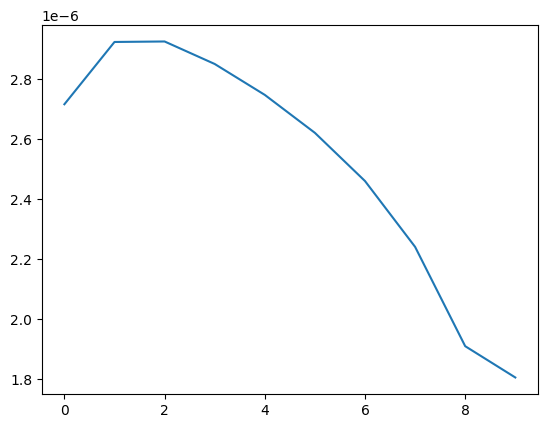

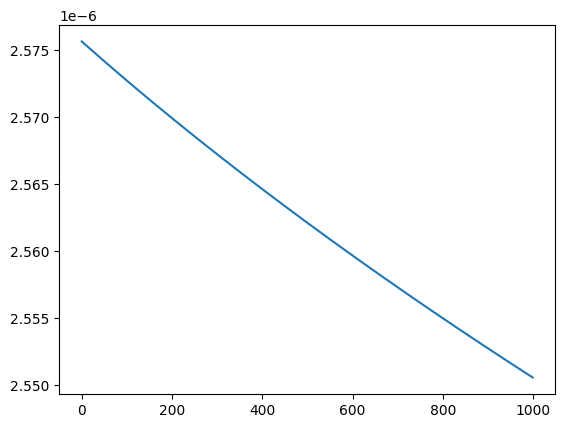

In [335]:
u1 = np.ones(1)
u1 = np.append(u1, W_prev)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
print(u1)

plt.plot(u1, label = 'prev')
plt.plot(u0, label = '0')
plt.legend()
plt.figure()
plt.plot(dW)
plt.figure()
plt.plot(errs)

# Attempt 2.1
simple iteration

In [339]:
def K(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    return k**3

In [340]:
N = 1000
h = 1/(N+1)
xi = np.linspace(h, 1 - h, N)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
tau = 10**(-5)                    # time step
g = 4                             # initial gamma
v0 = W0[-1]**2*W0[-2]/g/2/h       # initial velocity

# useful coeffitients
a = tau/(g*h)**2
b = tau*v0/(2*g*h)

W_prev = W0.copy()

errs = []
err = 1

dW_prev = np.zeros(N)
# for j in range(nt)            # time loop

steps = 0
max_iter = 1000
while err > 10**(-8):         # solving nonlinear equation for given time step

    # making matrix A
    
    k = K(W_prev)

    k0 = 1 + a*(k[1:] - k[:-1])
    k1 = -b*xi[:-1] - a*k[1:-1]
    k_1 = b*xi[1:] - a*k[1:-1]

    A = diags([k_1, k0, k1],[-1,0,1], format = 'csr')

    # right-hand side
    
    f = np.empty(N)
    f[0] = b*xi[0]*(W_prev[1] - 1) + a*(k[1]*(W_prev[1] - W0[0]) - k[0]*(W_prev[0] - 1))
    f[1:-1] = b*xi[1:-1]*(W_prev[2:] - W_prev[:-2]) + a*(k[2:-1]*(W_prev[2:] - W_prev[1:-1]) - k[1:-2]*(W_prev[1:-1] - W_prev[:-2]))
    f[-1] = b*xi[-1]*(-W_prev[-2]) + a*(k[-1]*(-W_prev[-1]) - k[-2]*(W_prev[-1] - W_prev[-2]))

    # solving system
    # dW = spsolve(A, f)

    dW = dW_prev - A@dW_prev + f
    
    # new solution
    # W_next = W_prev + dW

    err = np.sqrt(((dW - dW_prev)**2).mean())
    errs.append(err)

    if err > 1:
        break

    # W_prev = W_next.copy()
    dW_prev = dW.copy()

    steps += 1
    if steps == max_iter:
        break

W_prev = W0 + dW
print(steps, err)

84 1.062377357107137


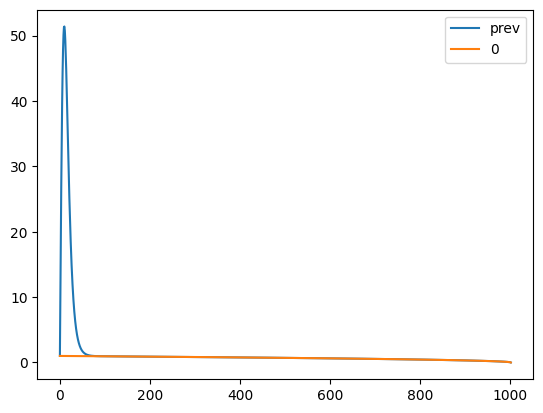

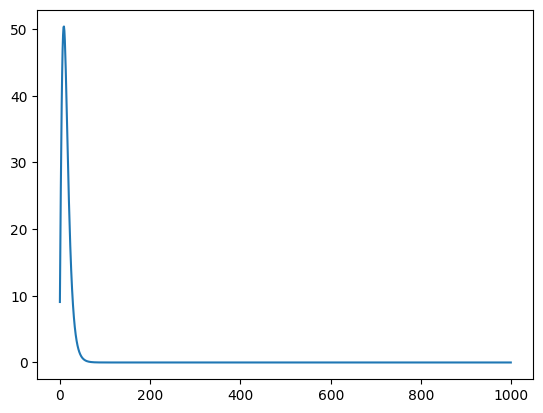

In [341]:
u1 = np.ones(1)
u1 = np.append(u1, W_prev)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
# print(u1)

plt.plot(u1, label = 'prev')
plt.plot(u0, label = '0')
plt.legend()
plt.figure()
plt.plot(dW)

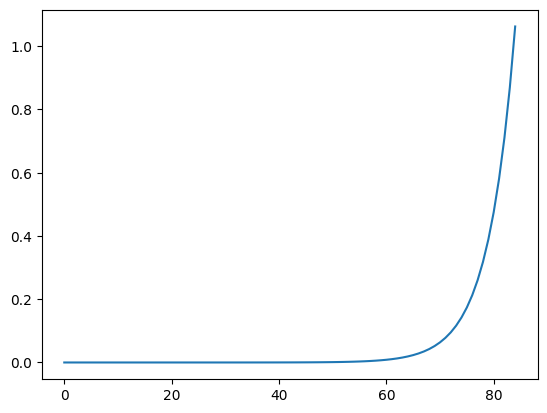

In [342]:
plt.plot(errs)

# Attempt 2.2
Newton method

In [336]:
N = 10
h = 1/(N+1)
xi = np.linspace(h, 1 - h, N)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
tau = 10**(-8)                    # time step
g = 0.1                           # initial gamma
v0 = W0[-1]**2*W0[-2]/g/2/h       # initial velocity

# useful coeffitients
a = tau/(g*h)**2
b = tau*v0/(2*g*h)

W_prev = W0.copy()
W1 = W0.copy()

errs = []
err = 1

dW_prev = np.zeros(N)
# for j in range(nt)            # time loop

steps = 0
max_iter = 1000
while err > 10**(-8):         # solving nonlinear equation for given time step

    # making matrix A
    
    k = K(W_prev)

    k0 = 1 + a*(k[1:] - k[:-1])
    k1 = -b*xi[:-1] - a*k[1:-1]
    k_1 = b*xi[1:] - a*k[1:-1]

    A = diags([k_1, k0, k1],[-1,0,1]).toarray()

    # right-hand side
    
    f = np.empty(N)
    f[0] = b*xi[0]*(W_prev[1] - 1) + a*(k[1]*(W_prev[1] - W0[0]) - k[0]*(W_prev[0] - 1))
    f[1:-1] = b*xi[1:-1]*(W_prev[2:] - W_prev[:-2]) + a*(k[2:-1]*(W_prev[2:] - W_prev[1:-1]) - k[1:-2]*(W_prev[1:-1] - W_prev[:-2]))
    f[-1] = b*xi[-1]*(-W_prev[-2]) + a*(k[-1]*(-W_prev[-1]) - k[-2]*(W_prev[-1] - W_prev[-2]))

    # solving system
    # dW = spsolve(A, f)
    # print(A.shape)
    # print(A)
    A_inv = np.linalg.inv(A)

    dW = dW_prev - A_inv @ ( A@dW_prev - f)
    
    # print(A@dW_prev - f)
    # new solution
    
    # W_next = W1 + dW
    # print(dW, dW_prev)
    err = np.sqrt(((dW - dW_prev)**2).mean())
    errs.append(err)

    if err > 1:
        break

    # W1 = W_next.copy()
    dW_prev = dW.copy()

    steps += 1
    if steps == max_iter:
        break

W_prev = W0 + dW
print(steps, err)

2 5.799238152015798e-23


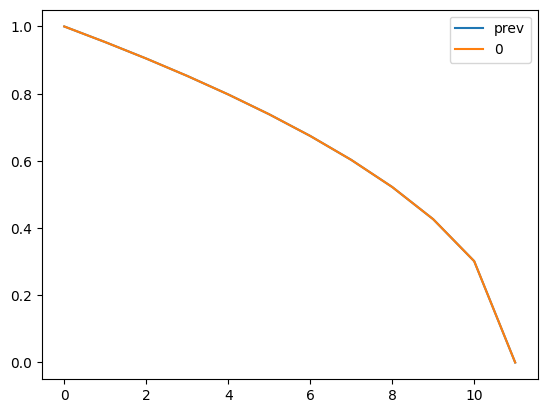

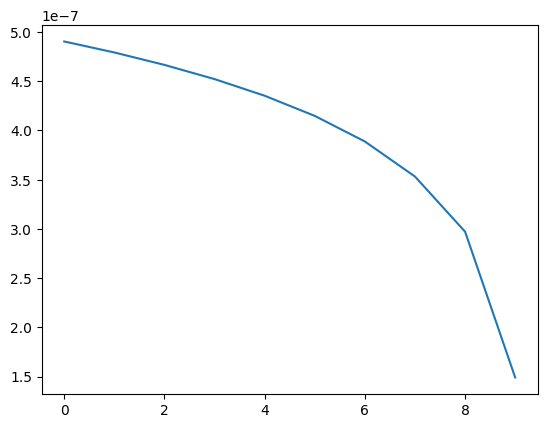

In [337]:
u1 = np.ones(1)
u1 = np.append(u1, W_prev)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
# print(u1)

plt.plot(u1, label = 'prev')
plt.plot(u0, label = '0')
plt.legend()
plt.figure()
plt.plot(dW)

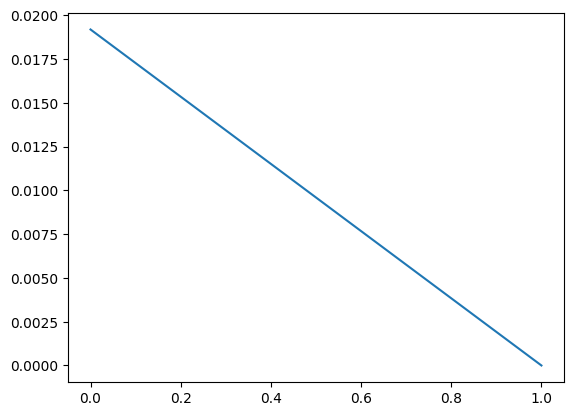

In [264]:
plt.plot(errs)

# Attempt 2.3

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from numba import njit
import time
from mpmath import *

## numba

In [ ]:
@njit
def psi_jit(w, g, h):
    psi0 = - ((w[0] + 1)/2)**3/g*(w[0] - 1)/h
    return psi0

@njit
def K_jit(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    if np.any(k < 0):
        return np.zeros(w.shape[0] + 1)
    return k**3

@njit
def dK_jit(w):
    k = K_jit(w)
    dk = 3/2*k**(2/3)
    return dk

@njit
def make_A_jit(w, xi, v, g, tau, h):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    k = K_jit(w)
    k0 = 1 + b*(k[1:] + k[:-1])
    k1 = -a*xi[:-1] - b*k[1:-1]
    k_1 = a*xi[1:] - b*k[1:-1]
    A = np.diag(k0) + np.diag(k1, 1) + np.diag(k_1, -1)
    return A

# right-hand side
@njit
def make_f_jit(w, xi, v, g, tau, h):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    k = K_jit(w)
    f = np.empty_like(w)
    f[0] = a*xi[0]*(w[1] - 1) + b*(k[1]*(w[1] - w[0]) - k[0]*(w[0] - 1))
    f[1:-1] = a*xi[1:-1]*(w[2:] - w[:-2]) + b*(k[2:-1]*(w[2:] - w[1:-1]) - k[1:-2]*(w[1:-1] - w[:-2]))
    f[-1] = a*xi[-1]*(-w[-2]) + b*(k[-1]*(-w[-1]) - k[-2]*(w[-1] - w[-2]))
    return f

# здесь в w уже входит dw
@njit
def make_F_jit(A, w, dw, xi, v, g, tau, h):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    k = K_jit(w)
    dk = dK_jit(w)
    # F = A.copy()
    if np.all(k == 0):
        print('a: ', a, ', b: ', b)
        print('k: ', k)
        print('dk: ', dk)
        print('A: ', A)
        print('w: ', w)
        print('dw: ', dw)
        return np.zeros(w.shape[[0]])
    
    # main diagonal
    F0 = np.empty_like(w)
    F0[0] = A[0,0] + dw[0]*b*(dk[1] + dk[0]) - dw[1]*b*dk[1] - b*(-(k[1] + k[0]) + dk[1]*(w[1] - w[0]) -dk[0]*(w[0] - 1))
    F0[1:-1] = np.diag(A)[1:-1] - dw[2:]*b*dk[2:-1] + dw[1:-1]*b*(dk[2:-1] + dk[1:-2]) - dw[:-2]*b*dk[1:-2] - b*(-(k[2:-1] + k[1:-2]) + dk[2:-1]*(w[2:] - w[1:-1]) - dk[1:-2]*(w[1:-1] - w[:-2]))
    F0[-1] = A[-1,-1] - dw[-2]*b*dk[-2] + dw[-1]*b*(dk[-1] + dk[-2]) - b*(-(k[-2] + k[-1]) - dk[-1]*w[-1] - dk[-2]*(w[-1] - w[-2]))

    # upper diagonal
    
    F1 = np.diag(A, 1) - b*dk[1:-1]*dw[1:] + b*dk[1:-1]*dw[:-1] - (a*xi[:-1] + b*k[1:-1] + b*dk[1:-1]*(w[1:] - w[:-1]))

    #lower diagonal
    F2 = np.diag(A, -1) + dw[1:]*b*dk[1:-1] - dw[:-1]*b*dk[1:-1] - (-a*xi[1:] + b*k[1:-1] - b*(w[1:] - w[:-1])*dk[1:-1])
    
    # F = diags([F2, F0, F1],[-1,0,1]).toarray()
    F = np.diag(F0) + np.diag(F1, 1) + np.diag(F2, -1)

    return F

# @njit
# def write_sol(w, t, g, psi, N, t_end, nt):
#     # name = f"{N:.1e}" + ',' + f"{nt:.1e}" + ',' + f"{t_end:.1e} + '.txt'"
#     name = 'hi.txt'
#     file = open(N, 'a') # append to file
#     file.write(str(t) + '\t' + str(g) + '\t' + str(psi) + '\t' + str(w) + '\n')
#     file.close()
#     return  sdfsdf 

@njit
def print_sol_jit(w, t, g, psi):
    print('t: ', t, ', g: ', g, ', psi: ', psi)
    print('W: ', w)
    return

# @njit


@njit
def get_solution_jit(t0, t_end, nt, N, n_write, n_print, g0, W0):
    
    tau = (t_end - t0)/nt
    h = 1/(N+1)
    xi = np.linspace(h, 1 - h, N)
    # W0 = np.sqrt(1 - xi)              # intitial solution of omega
    # W0 = analyt_sol(N)
    # g0 = 0.1                             # initial gamma
    v0 = W0[-1]**2*W0[-2]/g0/2/h       # initial velocity
    # t0 = 10**(-3)
    t = t0
    
    psi0 = psi_jit(W0, g0, h)

    v_prev = W0[-1]**2*W0[-2]/g0/2/h
    W_prev = np.copy(W0)
    g_prev = g0   

    ts = []
    gs = []
    psis = []
    gs.append(g0)
    ts.append(t0)
    psis.append(psi0)
    
    while t < t_end:   # time loop
        # print(t)
        steps = 0
        max_iter = 1000
        dW_prev = np.zeros(N)
        # errs = []
        err = 1
        # print(i)
        while err > 10**(-6):         # solving nonlinear equation for given time step
            
            # making matrix A
            A = make_A_jit(W_prev, xi, v_prev, g_prev, tau, h)
            
            # right-hand side
            f = make_f_jit(W_prev, xi, v_prev, g_prev, tau, h)
            
            F = make_F_jit(A, W_prev, dW_prev, xi, v_prev, g_prev, tau, h)
            if np.all(F == 0):
                print(F)
                print("k < 0")
                return 0
            b = np.linalg.solve(F, A @ dW_prev - f)
            dW = dW_prev - b
            
            # new solution
            W = W_prev + dW
            err = np.sqrt(((dW - dW_prev)**2).mean())
        
            if err > 1:
                print(int((t-t0)/tau), 'error > 1')
                break
        
            W_prev = np.copy(W)
            dW_prev = np.copy(dW)
    
            steps += 1
            if steps == max_iter:
                print(int((t-t0)/tau), 'maxiter')
                break
    
    
        g_prev = g_prev + v_prev*tau
        v_prev = W_prev[-1]**2*W_prev[-2]/g_prev/2/h
        t = t + tau
        if int(t/tau) % n_write == 0:
            psi = psi_jit(W_prev, g_prev, h)
            ts.append(t)
            gs.append(g_prev)
            psis.append(psi)
            
        if int(t/tau) % n_print == 0:
            # print(int((t-t0)/tau) % n_write)
            psi = psi_jit(W_prev, g_prev, h)
            # write_sol(W_prev, t, g_prev, psi, N, t_end, nt)
            print_sol_jit(W_prev, t, g_prev, psi)
    return W_prev, ts, gs, psis

## not numba

In [2]:
def calc_psi(w, g, h):
    psi0 = - ((w[0] + 1)/2)**3/g*(w[0] - 1)/h
    return psi0

# @njit
def K(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    if np.any(k < 0):
        return np.zeros(w.shape[0] + 1)
    return np.power(k,3)

# @njit
def dK(w):
    k = K(w)

    dk = 3/2*np.power(k,2/3)
    return dk

# @njit
def make_A(w, xi, v, g, tau, h):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    k = K(w)
    k0 = 1 + b*(k[1:] + k[:-1])
    k1 = -a*xi[:-1] - b*k[1:-1]
    k_1 = a*xi[1:] - b*k[1:-1]
    A = np.diag(k0) + np.diag(k1, 1) + np.diag(k_1, -1)
    return A

# right-hand side
# @njit
def make_f(w, xi, v, g, tau, h):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    k = K(w)
    f = np.empty_like(w)
    f[0] = a*xi[0]*(w[1] - 1) + b*(k[1]*(w[1] - w[0]) - k[0]*(w[0] - 1))
    f[1:-1] = a*xi[1:-1]*(w[2:] - w[:-2]) + b*(k[2:-1]*(w[2:] - w[1:-1]) - k[1:-2]*(w[1:-1] - w[:-2]))
    f[-1] = a*xi[-1]*(-w[-2]) + b*(k[-1]*(-w[-1]) - k[-2]*(w[-1] - w[-2]))
    return f

# здесь в w уже входит dw
# @njit
def make_F(A, w, dw, xi, v, g, tau, h):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    k = K(w)
    if np.all(k == 0):
        print('a: ', a, ', b: ', b)
        print('tau: ', tau, 'v: ', v, 'g: ', g)
        return np.zeros(w.shape[0])
    dk = dK(w)
    # main diagonal
    F0 = np.empty_like(w)
    F0[0] = A[0,0] + dw[0]*b*(dk[1] + dk[0]) - dw[1]*b*dk[1] - b*(-(k[1] + k[0]) + dk[1]*(w[1] - w[0]) -dk[0]*(w[0] - 1))
    F0[1:-1] = np.diag(A)[1:-1] - dw[2:]*b*dk[2:-1] + dw[1:-1]*b*(dk[2:-1] + dk[1:-2]) - dw[:-2]*b*dk[1:-2] - b*(-(k[2:-1] + k[1:-2]) + dk[2:-1]*(w[2:] - w[1:-1]) - dk[1:-2]*(w[1:-1] - w[:-2]))
    F0[-1] = A[-1,-1] - dw[-2]*b*dk[-2] + dw[-1]*b*(dk[-1] + dk[-2]) - b*(-(k[-2] + k[-1]) - dk[-1]*w[-1] - dk[-2]*(w[-1] - w[-2]))

    # upper diagonal
    
    F1 = np.diag(A, 1) - b*dk[1:-1]*dw[1:] + b*dk[1:-1]*dw[:-1] - (a*xi[:-1] + b*k[1:-1] + b*dk[1:-1]*(w[1:] - w[:-1]))

    #lower diagonal
    F2 = np.diag(A, -1) + dw[1:]*b*dk[1:-1] - dw[:-1]*b*dk[1:-1] - (-a*xi[1:] + b*k[1:-1] - b*(w[1:] - w[:-1])*dk[1:-1])
    
    F = np.diag(F0) + np.diag(F1, 1) + np.diag(F2, -1)

    
    return F

# @njit
def print_sol(w, t, g, psi):
    print('t: ', t, ', g: ', g, ', psi: ', psi)
    print('W: ', w)
    return

# @njit
def get_solution(t0, t_end, nt, N, n_write, n_print, g0, W0):
    tau = (t_end - t0)/nt
    h = 1/(N+1)
    xi = np.linspace(h, 1 - h, N)
    # W0 = np.sqrt(1 - xi)              # intitial solution of omega
    # W0 = analyt_sol(N)
    # g0 = 0.1                             # initial gamma
    v0 = W0[-1]**2*W0[-2]/g0/2/h       # initial velocity
    # t0 = 10**(-3)
    t = t0
    
    psi0 = calc_psi(W0, g0, h)

    v_prev = W0[-1]**2*W0[-2]/g0/2/h
    W_prev = np.copy(W0)
    g_prev = g0   

    ts = []
    gs = []
    psis = []
    gs.append(g0)
    ts.append(t0)
    psis.append(psi0)
    
    while t < t_end:    # time loop
        steps = 0
        max_iter = 1000
        dW_prev = np.zeros(N)
        # errs = []
        err = 1
        # print(i)
        while err > 10**(-6):         # solving nonlinear equation for given time step
            
            # making matrix A
            A = make_A(W_prev, xi, v_prev, g_prev, tau, h)
            
            # right-hand side
            f = make_f(W_prev, xi, v_prev, g_prev, tau, h)
            
            F = make_F(A, W_prev, dW_prev, xi, v_prev, g_prev, tau, h)
            if np.all(F == 0):
                # print(F)
                print("k < 0")
                return W_prev, ts, gs, psis
            b = np.linalg.solve(F, A @ dW_prev - f)
            dW = dW_prev - b
            # new solution
            W = W_prev + dW
            err = np.sqrt(np.power(dW - dW_prev,2).mean())
        
            if err > 1:
                print(i, 'error > 1')
                break
        
            W_prev = np.copy(W)
            dW_prev = np.copy(dW)
    
            steps += 1
            if steps == max_iter:
                print(i)
                break
    
    
        g_prev = g_prev + v_prev*tau
        v_prev = W_prev[-1]**2*W_prev[-2]/g_prev/2/h
        t = t+tau
        if int(t/tau) % n_write == 0:
            psi = calc_psi(W_prev, g_prev, h)
            ts.append(t)
            gs.append(g_prev)
            psis.append(psi)
            
        if int(t/tau) % n_print == 0:
            # print(int((t-t0)/tau) % n_write)
            psi = calc_psi(W_prev, g_prev, h)
            # write_sol(W_prev, t, g_prev, psi, N, t_end, nt)
            print_sol(W_prev, t, g_prev, psi)
    return W_prev, ts, gs, psis

In [3]:
from mpmath import *
def analyt_sol(N):
    a = [0.73658, 3.22225e-2, 0.28157e-2, 0.20421e-2, 0.79333e-3, 0.58367e-3, 0.27394e-3, 0.17645e-3, 0.64422e-4, 0.33006e-4]
    b_0 = 0.28924
    omega_ksi = []
    for ksi in np.linspace(0.0,1,N+2):
        omega = 0
        for i in range(10):
            omega += a[i]*(1-ksi**2)**(1/3)*gegenbauer(2*(i+1) -2, 5/6, ksi)
        omega+=b_0*(1-ksi)
        omega_ksi.append(omega)

    W0 = np.array(omega_ksi).astype(np.float64)[1:-1]
    return W0

In [9]:
t0 = 0
t_end = 10**(1)
g0 = 0.86998
nt = 10**4
N = 10
n_write = 10**2
n_print = 10**3

W0 = analyt_sol(N)
h = 1/(N+1)
xi = np.linspace(h,1-h,N)
W0 = np.sqrt(1 - xi)
W, ts, gs, psis = get_solution(t0, t_end, nt, N, n_write, n_print, g0, W0)

t:  1.0000000000000007 , g:  1.3049572578267017 , psi:  0.23532699575162583
W:  [0.97082428 0.93890493 0.90372982 0.86460777 0.82056833 0.77017702
 0.71115963 0.63952516 0.54703181 0.4103126 ]
t:  2.0009999999998906 , g:  1.6484209727586716 , psi:  0.186279336698235
W:  [0.97082675 0.93891028 0.90373846 0.8646201  0.82058473 0.77019783
 0.71118509 0.63955531 0.5470664  0.41035092]
t:  3.0009999999997805 , g:  1.9315006139315927 , psi:  0.15897760121654178
W:  [0.9708269  0.93891059 0.90373896 0.86462081 0.82058568 0.77019903
 0.71118655 0.63955704 0.54706839 0.41035312]
t:  4.000999999999671 , g:  2.1780918623762497 , psi:  0.14097896509253827
W:  [0.97082691 0.93891063 0.90373903 0.86462091 0.82058581 0.77019919
 0.71118675 0.63955728 0.54706866 0.41035342]
t:  5.000000000000004 , g:  2.3992601974849994 , psi:  0.12798323996799718
W:  [0.97082692 0.93891064 0.90373904 0.86462093 0.82058583 0.77019923
 0.7111868  0.63955733 0.54706872 0.41035349]
t:  6.000000000000338 , g:  2.601887869

[1.         0.97082692 0.93891064 0.90373905 0.86462094 0.82058585
 0.77019925 0.71118682 0.63955736 0.54706875 0.41035352 0.        ]


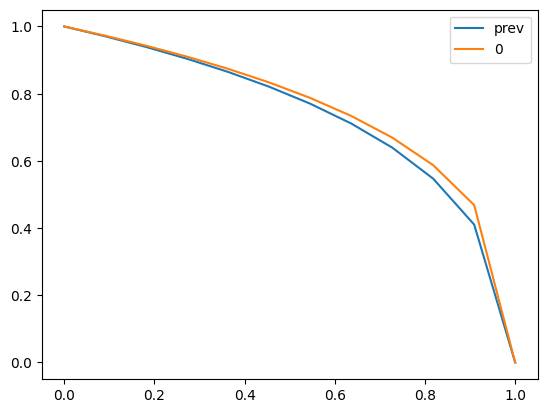

In [11]:
xi = np.linspace(0,1,N+2)
# u0 = np.sqrt(1 - xi)
W0 = analyt_sol(N)
u1 = np.ones(1)
u1 = np.append(u1, W)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
print(u1)

plt.plot(xi,u1, label = 'prev')
plt.plot(xi,u0, label = '0')
plt.legend()

# add sign B

## numba

### functions

In [153]:
def analyt_sol(N):
    a = [0.73658, 3.22225e-2, 0.28157e-2, 0.20421e-2, 0.79333e-3, 0.58367e-3, 0.27394e-3, 0.17645e-3, 0.64422e-4, 0.33006e-4]
    b_0 = 0.28924
    omega_ksi = []
    for ksi in np.linspace(0.0,1,N+2):
        omega = 0
        for i in range(10):
            omega += a[i]*(1-ksi**2)**(1/3)*gegenbauer(2*(i+1) -2, 5/6, ksi)
        omega+=b_0*(1-ksi)
        omega_ksi.append(omega)

    W0 = np.array(omega_ksi).astype(np.float64)[1:-1]
    return W0

@njit
def calc_psi_B_jit(w, g, h, sgnB):
    psi0 = - ((w[0] + 1)/2)**3/g*((w[0] - 1)/h - g*sgnB)
    return psi0

@njit
def K_jit(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    if np.any(k < 0):
        return np.zeros(w.shape[0] + 1)
    return np.power(k,3)

@njit
def dK_jit(w):
    k = K_jit(w)
    dk = 3/2*np.power(k,2/3)
    return dk

@njit
def make_A_jit(w, xi, v, g, tau, h):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    k = K_jit(w)
    k0 = 1 + b*(k[1:] + k[:-1])
    k1 = -a*xi[:-1] - b*k[1:-1]
    k_1 = a*xi[1:] - b*k[1:-1]
    A = np.diag(k0) + np.diag(k1, 1) + np.diag(k_1, -1)
    return A

# right-hand side
@njit
def make_f_B_jit(w, xi, v, g, tau, h, sgnB):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    c = g*h*sgnB
    k = K_jit(w)
    f = np.empty_like(w)
    f[0] = a*xi[0]*(w[1] - 1) + b*(k[1]*(w[1] - w[0] - c) - k[0]*(w[0] - 1 - c))
    f[1:-1] = a*xi[1:-1]*(w[2:] - w[:-2]) + b*(k[2:-1]*(w[2:] - w[1:-1] - c) - k[1:-2]*(w[1:-1] - w[:-2] - c))
    f[-1] = a*xi[-1]*(-w[-2]) + b*(k[-1]*(-w[-1] - c) - k[-2]*(w[-1] - w[-2] - c))
    return f

# здесь в w уже входит dw
@njit
def make_F_B_jit(A, w, dw, xi, v, g, tau, h, sgnB):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    c = g*h*sgnB
    # print(1)
    k = K_jit(w)
    # print(2)
    if np.all(k == 0):
        print('a: ', a, ', b: ', b)
        print('tau: ', tau, 'v: ', v, 'g: ', g)
        # print('1',np.zeros((w.shape[0], w.shape[0])).shape)
        return np.zeros((w.shape[0], w.shape[0])).astype(np.float64)
    dk = dK_jit(w)
    # main diagonal
    F0 = np.empty_like(w)
    F0[0] = A[0,0] + dw[0]*b*(dk[1] + dk[0]) - dw[1]*b*dk[1] - b*(-(k[1] + k[0]) + dk[1]*(w[1] - w[0] - c) -dk[0]*(w[0] - 1 - c))
    F0[1:-1] = np.diag(A)[1:-1] - dw[2:]*b*dk[2:-1] + dw[1:-1]*b*(dk[2:-1] + dk[1:-2]) - dw[:-2]*b*dk[1:-2] - b*(-(k[2:-1] + k[1:-2]) + dk[2:-1]*(w[2:] - w[1:-1] - c) - dk[1:-2]*(w[1:-1] - w[:-2] - c))
    F0[-1] = A[-1,-1] - dw[-2]*b*dk[-2] + dw[-1]*b*(dk[-1] + dk[-2]) - b*(-(k[-2] + k[-1]) - dk[-1]*(w[-1] - c) - dk[-2]*(w[-1] - w[-2] - c))
    # upper diagonal
    F1 = np.diag(A, 1) - b*dk[1:-1]*dw[1:] + b*dk[1:-1]*dw[:-1] - (a*xi[:-1] + b*k[1:-1] + b*dk[1:-1]*(w[1:] - w[:-1] - c))
    #lower diagonal
    F2 = np.diag(A, -1) + dw[1:]*b*dk[1:-1] - dw[:-1]*b*dk[1:-1] - (-a*xi[1:] + b*k[1:-1] - b*(w[1:] - w[:-1] - c)*dk[1:-1])
    F = np.diag(F0) + np.diag(F1, 1) + np.diag(F2, -1)
    # print(F.dtype)
    # print(F.shape)
    return F.astype(np.float64)

@njit
def print_sol_jit(w, t, g, psi, v):
    print('t: ', t, ', g: ', g, ', psi: ', psi, ', v: ', v)
    print('W: ', w)
    return

@njit
def get_solution_B_jit(t0, t_end, nt, N, n_write, n_print, g0, W0, sgnB):
    tau = (t_end - t0)/nt
    h = 1/(N+1)
    xi = np.linspace(h, 1 - h, N)
    v0 = W0[-1]**2*(W0[-2]/2/h + g0*sgnB)/g0       # initial velocity
    t = t0
    psi0 = calc_psi_B_jit(W0, g0, h, sgnB)
    v_prev = v0
    W_prev = np.copy(W0)
    g_prev = g0   
    ts = []
    gs = []
    psis = []
    gs.append(g0)
    ts.append(t0)
    psis.append(psi0)
    
    while t < t_end:    # time loop
        steps = 0
        max_iter = 1000
        dW_prev = np.zeros(N)
        err = 1
        while err > 10**(-4):         # solving nonlinear equation for given time step
            A = make_A_jit(W_prev, xi, v_prev, g_prev, tau, h)          # making matrix A
            f = make_f_B_jit(W_prev, xi, v_prev, g_prev, tau, h, sgnB)         # right-hand side
            F = make_F_B_jit(A, W_prev, dW_prev, xi, v_prev, g_prev, tau, h, sgnB)
            if np.all(F == 0):
                print("k < 0")
                return W_prev, ts, gs, psis
            b = np.linalg.solve(F, A @ dW_prev - f)
            dW = dW_prev - b
            # new solution
            W = W_prev + dW
            err = np.sqrt(np.power(dW - dW_prev,2).mean())
            if err > 1:
                print('error > 1')
                break
            W_prev = np.copy(W)
            dW_prev = np.copy(dW)
            steps += 1
            if steps == max_iter:
                print(steps, 'maxiter')
                break
        
        v_prev = W_prev[-1]**2*(W_prev[-2]/2/h + g_prev*sgnB)/g_prev
        # if sgnB == 1:
            # if v_prev > 1:
                # v_prev = 1
        g_prev = g_prev + v_prev*tau

        t = t+tau
        if int(t/tau) % n_write == 0:
            psi = calc_psi_B_jit(W_prev, g_prev, h, sgnB)
            ts.append(t)
            gs.append(g_prev)
            psis.append(psi)
        if int(t/tau) % n_print == 0:
            psi = calc_psi_B_jit(W_prev, g_prev, h, sgnB)
            # print_sol_jit(W_prev, t, g_prev, psi, v_prev)
    return W_prev, ts, gs, psis

### solving

In [ ]:
t0 = 0
t_end = 10**(2)
g0 = 0.1
nt = 10**7
N = 100
n_write = 10**2
n_print = 10**6
# sgnB = 0
W0 = analyt_sol(N)
# W_small, ts_small, gs_small, psis_small = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, 0)

start_time = time.time()
W_small_1, ts_small_1, gs_small_1, psis_small_1 = get_solution_B_jit(t0, t_end, nt, N, n_write, n_print, g0, W0, 1)
# W_small_2, ts_small_2, gs_small_2, psis_small_2 = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, -1)

print("--- %s seconds ---" % (time.time() - start_time))

## not numba

In [121]:
np.array([1,2,3]).dtype


dtype('int32')

### functions

In [48]:
def calc_psi_B(w, g, h, sgnB):
    psi0 = - ((w[0] + 1)/2)**3/g*((w[0] - 1)/h - g*sgnB)
    return psi0

def K(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    if np.any(k < 0):
        return np.zeros(w.shape[0] + 1)
    return np.power(k,3)

def dK(w):
    k = K(w)
    dk = 3/2*np.power(k,2/3)
    return dk

def make_A(w, xi, v, g, tau, h):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    k = K(w)
    k0 = 1 + b*(k[1:] + k[:-1])
    k1 = -a*xi[:-1] - b*k[1:-1]
    k_1 = a*xi[1:] - b*k[1:-1]
    A = np.diag(k0) + np.diag(k1, 1) + np.diag(k_1, -1)
    return A

# right-hand side
def make_f_B(w, xi, v, g, tau, h, sgnB):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    c = g*h*sgnB
    k = K(w)
    f = np.empty_like(w)
    f[0] = a*xi[0]*(w[1] - 1) + b*(k[1]*(w[1] - w[0] - c) - k[0]*(w[0] - 1 - c))
    f[1:-1] = a*xi[1:-1]*(w[2:] - w[:-2]) + b*(k[2:-1]*(w[2:] - w[1:-1] - c) - k[1:-2]*(w[1:-1] - w[:-2] - c))
    f[-1] = a*xi[-1]*(-w[-2]) + b*(k[-1]*(-w[-1] - c) - k[-2]*(w[-1] - w[-2] - c))
    return f

# здесь в w уже входит dw
def make_F_B(A, w, dw, xi, v, g, tau, h, sgnB):
    b = tau/(g*h)**2
    a = tau*v/(2*g*h)
    c = g*h*sgnB
    k = K(w)
    if np.all(k == 0):
        print('a: ', a, ', b: ', b)
        print('tau: ', tau, 'v: ', v, 'g: ', g)
        return np.zeros(w.shape[0])
    dk = dK(w)
    # main diagonal
    F0 = np.empty_like(w)
    F0[0] = A[0,0] + dw[0]*b*(dk[1] + dk[0]) - dw[1]*b*dk[1] - b*(-(k[1] + k[0]) + dk[1]*(w[1] - w[0] - c) -dk[0]*(w[0] - 1 - c))
    F0[1:-1] = np.diag(A)[1:-1] - dw[2:]*b*dk[2:-1] + dw[1:-1]*b*(dk[2:-1] + dk[1:-2]) - dw[:-2]*b*dk[1:-2] - b*(-(k[2:-1] + k[1:-2]) + dk[2:-1]*(w[2:] - w[1:-1] - c) - dk[1:-2]*(w[1:-1] - w[:-2] - c))
    F0[-1] = A[-1,-1] - dw[-2]*b*dk[-2] + dw[-1]*b*(dk[-1] + dk[-2]) - b*(-(k[-2] + k[-1]) - dk[-1]*(w[-1] - c) - dk[-2]*(w[-1] - w[-2] - c))

    # upper diagonal
    F1 = np.diag(A, 1) - b*dk[1:-1]*dw[1:] + b*dk[1:-1]*dw[:-1] - (a*xi[:-1] + b*k[1:-1] + b*dk[1:-1]*(w[1:] - w[:-1] - c))

    #lower diagonal
    F2 = np.diag(A, -1) + dw[1:]*b*dk[1:-1] - dw[:-1]*b*dk[1:-1] - (-a*xi[1:] + b*k[1:-1] - b*(w[1:] - w[:-1] - c)*dk[1:-1])
    
    F = np.diag(F0) + np.diag(F1, 1) + np.diag(F2, -1)
    return F

def print_sol(w, t, g, psi, v):
    print('t: ', t, ', g: ', g, ', psi: ', psi, ', v: ', v)
    print('W: ', w)
    return

def get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, sgnB):
    tau = (t_end - t0)/nt
    h = 1/(N+1)
    xi = np.linspace(h, 1 - h, N)
    v0 = W0[-1]**2*(W0[-2]/2/h + g0*sgnB)/g0       # initial velocity
    t = t0
    psi0 = calc_psi_B(W0, g0, h, sgnB)
    v_prev = v0
    W_prev = np.copy(W0)
    g_prev = g0   
    ts = []
    gs = []
    psis = []
    gs.append(g0)
    ts.append(t0)
    psis.append(psi0)
    
    while t < t_end:    # time loop
        steps = 0
        max_iter = 1000
        dW_prev = np.zeros(N)
        err = 1
        while err > 10**(-4):         # solving nonlinear equation for given time step
            A = make_A(W_prev, xi, v_prev, g_prev, tau, h)          # making matrix A
            f = make_f_B(W_prev, xi, v_prev, g_prev, tau, h, sgnB)         # right-hand side
            F = make_F_B(A, W_prev, dW_prev, xi, v_prev, g_prev, tau, h, sgnB)
            if np.all(F == 0):
                print("k < 0")
                return W_prev, ts, gs, psis
            b = np.linalg.solve(F, A @ dW_prev - f)
            dW = dW_prev - b
            # new solution
            W = W_prev + dW
            err = np.sqrt(np.power(dW - dW_prev,2).mean())
            if err > 1:
                print(i, 'error > 1')
                break
            W_prev = np.copy(W)
            dW_prev = np.copy(dW)
            steps += 1
            if steps == max_iter:
                print(i)
                break
        
        v_prev = W_prev[-1]**2*(W_prev[-2]/2/h + g_prev*sgnB)/g_prev
        # if sgnB == 1:
            # if v_prev > 1:
                # v_prev = 1
        g_prev = g_prev + v_prev*tau

        t = t+tau
        if int(t/tau) % n_write == 0:
            psi = calc_psi_B(W_prev, g_prev, h, sgnB)
            ts.append(t)
            gs.append(g_prev)
            psis.append(psi)
        if int(t/tau) % n_print == 0:
            psi = calc_psi_B(W_prev, g_prev, h, sgnB)
            print_sol(W_prev, t, g_prev, psi, v_prev)
    return W_prev, ts, gs, psis

### решение на малых временах

In [46]:
t0 = 0
t_end = 10**(0)
g0 = 0.1
nt = 10**5
N = 10
n_write = 10**3
n_print = 10**5
sgnB = 0
W0 = analyt_sol(N)
# W_small, ts_small, gs_small, psis_small = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, 0)
W_small_1, ts_small_1, gs_small_1, psis_small_1 = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, 1)
# W_small_2, ts_small_2, gs_small_2, psis_small_2 = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, -1)

KeyboardInterrupt: 

In [ ]:
t0 = 0
t_end = 10**(1)
g0 = 0.1
nt = 10**5
N = 10
n_write = 10**2
n_print = 10**4
# sgnB = 0
W0 = analyt_sol(N)
# W_small, ts_small, gs_small, psis_small = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, 0)
W_small_1, ts_small_1, gs_small_1, psis_small_1 = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, 1)
# W_small_2, ts_small_2, gs_small_2, psis_small_2 = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, -1)

t:  1.0000999999999063 , g:  1.7829170777354495 , psi:  1.013603142744225 , v:  1.3826520124199035
W:  [0.99707132 0.9924922  0.98557929 0.97536454 0.96043726 0.93865355
 0.90654733 0.85796253 0.78013273 0.63706734]
t:  2.0000999999997964 , g:  3.1551099683408346 , psi:  1.0008352827815692 , v:  1.3767766072810435
W:  [0.9995791  0.9986843  0.9969381  0.99370042 0.98788488 0.9776203
 0.95957147 0.92738691 0.86733594 0.74032278]
t:  3.0000000000019065 , g:  4.547551956211587 , psi:  1.0000454000532935 , v:  1.4100896197394317
W:  [0.99995058 0.9998041  0.99942906 0.99854411 0.99656073 0.99225958
 0.98309711 0.96358554 0.92080659 0.81677424]


In [42]:
t0 = 0
t_end = 10**(1)
g0 = 0.1
nt = 10**6
N = 20
n_write = 10**3
n_print = 10**5
sgnB = 0
W0 = analyt_sol(N)
# W_small, ts_small, gs_small, psis_small = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, 0)
W_small_1, ts_small_1, gs_small_1, psis_small_1 = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, 1)
# W_small_2, ts_small_2, gs_small_2, psis_small_2 = get_solution_B(t0, t_end, nt, N, n_write, n_print, g0, W0, -1)

t:  1.0000099999980838 , g:  1.6925595217481595 , psi:  1.0160531407327837
W:  [0.99852465 0.99666305 0.99434032 0.99146758 0.98793891 0.98362723
 0.97837901 0.9720071  0.96428081 0.95491209 0.94353549 0.92967829
 0.91271426 0.89178859 0.865689   0.83260735 0.78965336 0.73171497
 0.64814462 0.50831846]
t:  2.000000000004635 , g:  2.972942152019134 , psi:  1.0012650553124196
W:  [0.99977253 0.99943618 0.99895266 0.9982718  0.99732793 0.99603512
 0.99428086 0.99191744 0.98875013 0.98452052 0.97888255 0.97136688
 0.96132597 0.94784531 0.92959158 0.9045327  0.86936842 0.81819893
 0.73866423 0.59517483]
t:  3.000000000011186 , g:  4.260726953642601 , psi:  1.0001113152631986
W:  [0.99996753 0.99991128 0.99981839 0.99966996 0.99943823 0.9990828
 0.99854493 0.9977395  0.99654323 0.99477736 0.99218189 0.98837636
 0.9827986  0.97460523 0.96250142 0.94442844 0.91693143 0.87368947
 0.80127536 0.66084669]
t:  4.000000000017737 , g:  5.572512363848386 , psi:  1.000009557050706
W:  [0.99999579 0.999

KeyboardInterrupt: 

[1.         0.97192815 0.94130358 0.90764154 0.87028376 0.82829879
 0.78029707 0.7240527  0.65561851 0.56677345 0.43417281 0.        ]


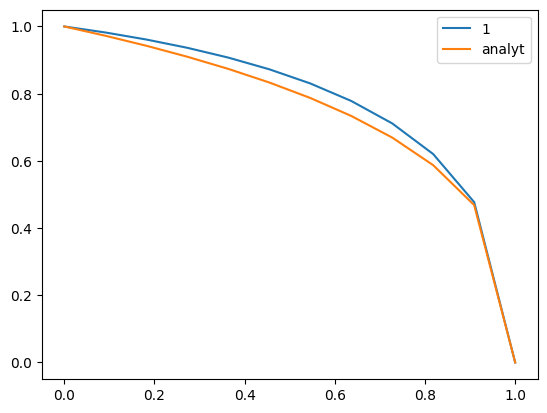

In [40]:
xi = np.linspace(0,1,N+2)
# u0 = np.sqrt(1 - xi)

u1 = np.ones(1)
u1 = np.append(u1, W_small)
u1 = np.append(u1, 0)

u2 = np.ones(1)
u2 = np.append(u2, W_small_1)
u2 = np.append(u2, 0)

u3 = np.ones(1)
u3 = np.append(u3, W_small_2)
u3 = np.append(u3, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
print(u1)

# plt.plot(xi,u1, label = '0')
plt.plot(xi,u2, label = '1')
# plt.plot(xi,u3, label = '-1')
plt.plot(xi,u0, label = 'analyt')
plt.legend()

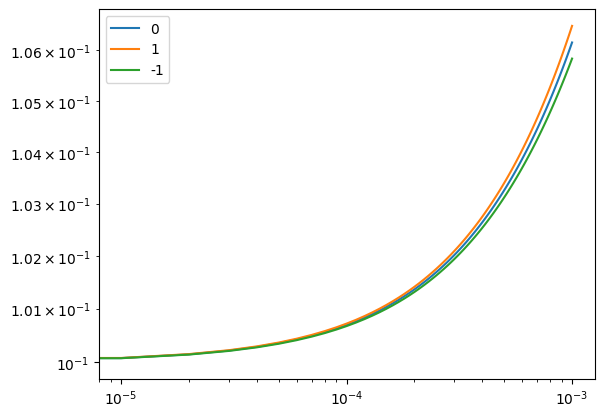

In [21]:
plt.plot(ts_small, gs_small, label = '0')
plt.plot(ts_small_1, gs_small_1, label = '1')
plt.plot(ts_small_2, gs_small_2, label = '-1')
plt.legend()
plt.xscale('log')
plt.yscale('log')

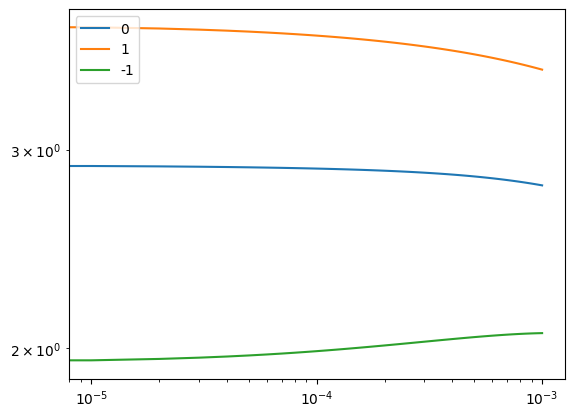

In [25]:
plt.plot(ts_small, psis_small, label = '0')
plt.plot(ts_small_1, psis_small_1, label = '1')
plt.plot(ts_small_2, psis_small_2, label = '-1')
plt.legend()
plt.xscale('log')
plt.yscale('log')

### решение используя предварительный расчет

In [32]:
# t0 = ts_small[-1]
t_end = 10**(2)
nt = 10**4
N = 10
n_write = 10**2
n_print = 10**1
# print('first \n')
# W_big, ts_big, gs_big, psis_big = get_solution_B(t0, t_end, nt, N, n_write, n_print, gs_small[-1], np.copy(W_small), 0)
# print('\n second \n')
W_big_1, ts_big_1, gs_big_1, psis_big_1 = get_solution_B(t0, t_end, nt, N, n_write, n_print, gs_small_1[-1], np.copy(W_small_1), 1)
# print('\n third \n')
# W_big_2, ts_big_2, gs_big_2, psis_big_2 = get_solution_B(t0, t_end, nt, N, n_write, n_print, gs_small_2[-1], np.copy(W_small_2), -1)

first 

t:  9.999900100017397 , g:  3.1849343606432874 , psi:  0.09641174310831502
W:  [0.97082692 0.93891064 0.90373905 0.86462094 0.82058585 0.77019925
 0.71118682 0.63955736 0.54706875 0.41035352]
t:  19.999800090038217 , g:  4.503001605898129 , psi:  0.06819119784300891
W:  [0.97082692 0.93891064 0.90373905 0.86462094 0.82058585 0.77019925
 0.71118682 0.63955736 0.54706875 0.41035352]
t:  29.99970008005904 , g:  5.5145473762383785 , psi:  0.055682733766745436
W:  [0.97082692 0.93891064 0.90373905 0.86462094 0.82058585 0.77019925
 0.71118682 0.63955736 0.54706875 0.41035352]
t:  39.99960007007986 , g:  6.367373012886753 , psi:  0.04822476597078977
W:  [0.97082692 0.93891064 0.90373905 0.86462094 0.82058585 0.77019925
 0.71118682 0.63955736 0.54706875 0.41035352]
t:  49.99950006010068 , g:  7.118752964643802 , psi:  0.04313467188990322
W:  [0.97082692 0.93891064 0.90373905 0.86462094 0.82058585 0.77019925
 0.71118682 0.63955736 0.54706875 0.41035352]
t:  59.9994000501215 , g:  7.7980

[1.         0.97082692 0.93891064 0.90373905 0.86462094 0.82058585
 0.77019925 0.71118682 0.63955736 0.54706875 0.41035352 0.        ]


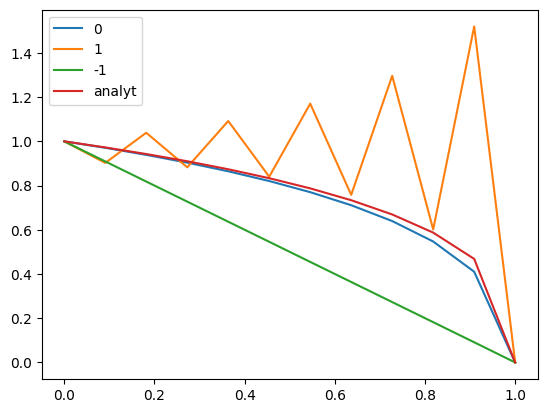

In [33]:
xi = np.linspace(0,1,N+2)
# u0 = np.sqrt(1 - xi)

u1 = np.ones(1)
u1 = np.append(u1, W_big)
u1 = np.append(u1, 0)

u2 = np.ones(1)
u2 = np.append(u2, W_big_1)
u2 = np.append(u2, 0)

u3 = np.ones(1)
u3 = np.append(u3, W_big_2)
u3 = np.append(u3, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
print(u1)

plt.plot(xi,u1, label = '0')
plt.plot(xi,u2, label = '1')
plt.plot(xi,u3, label = '-1')
plt.plot(xi,u0, label = 'analyt')
plt.legend()

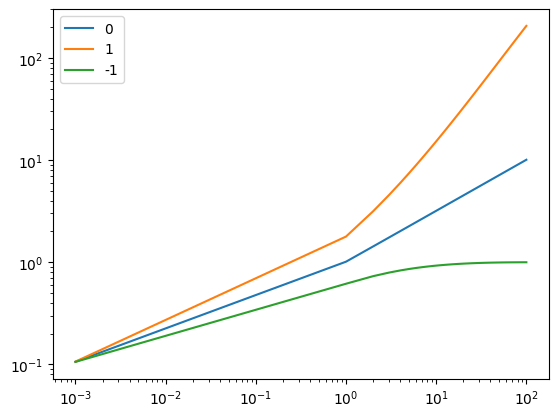

In [34]:
plt.plot(ts_big, gs_big, label = '0')
plt.plot(ts_big_1, gs_big_1, label = '1')
plt.plot(ts_big_2, gs_big_2, label = '-1')
plt.legend()
plt.xscale('log')
plt.yscale('log')

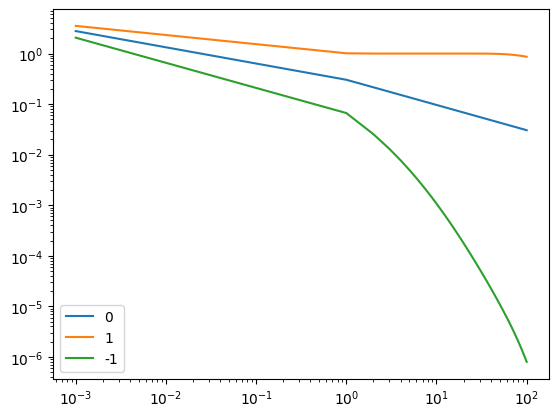

In [35]:
plt.plot(ts_big, psis_big, label = '0')
plt.plot(ts_big_1, psis_big_1, label = '1')
plt.plot(ts_big_2, psis_big_2, label = '-1')
plt.legend()
plt.xscale('log')
plt.yscale('log')

# dimension solution

In [ ]:
def analyt_sol(N):
    a = [0.73658, 3.22225e-2, 0.28157e-2, 0.20421e-2, 0.79333e-3, 0.58367e-3, 0.27394e-3, 0.17645e-3, 0.64422e-4, 0.33006e-4]
    b_0 = 0.28924
    omega_ksi = []
    for ksi in np.linspace(0.0,1,N+2):
        omega = 0
        for i in range(10):
            omega += a[i]*(1-ksi**2)**(1/3)*gegenbauer(2*(i+1) -2, 5/6, ksi)
        omega+=b_0*(1-ksi)
        omega_ksi.append(omega)

    W0 = np.array(omega_ksi).astype(type)[1:-1]
    return W0

@njit
def calc_psi_B_jit(w, g, h, sgnB):
    psi0 = - ((w[0] + 1)/2)**3/g*((w[0] - 1)/h - g*sgnB)
    return psi0

@njit
def K_jit(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    if np.any(k < 0):
        return np.zeros(w.shape[0] + 1)
    return np.power(k,3)

@njit
def dK_jit(w):
    k = K_jit(w)
    dk = 3/2*np.power(k,2/3)
    return dk

@njit
def make_A_jit(w, xi, k, h, a, b):
    # b = tau/(g*h)**2
    # a = tau*v/(2*g*h)
    # k = K_jit(w)
    # k0 = 
    # k1 = -b*xi[:-1] - b*k[1:-1]
    # k_1 = b*xi[1:] - b*k[1:-1]
    A = (np.diag(1 + a*(k[1:] + k[:-1])) + 
         np.diag(-b*xi[:-1] - b*k[1:-1], 1) + 
         np.diag(b*xi[1:] - b*k[1:-1], -1)).astype(type)
    return A

# right-hand side
@njit
def make_f_B_jit(w, xi, k, h, a, b, c):
    # b = tau/(g*h)**2
    # a = tau*v/(2*g*h)
    # c = g*h*sgnB
    # k = K_jit(w)
    f = np.empty_like(w)
    f[0] = b*xi[0]*(w[1] - 1) + a*(k[1]*(w[1] - w[0] - c) - k[0]*(w[0] - 1 - c))
    f[1:-1] = b*xi[1:-1]*(w[2:] - w[:-2]) + a*(k[2:-1]*(w[2:] - w[1:-1] - c) - k[1:-2]*(w[1:-1] - w[:-2] - c))
    f[-1] = b*xi[-1]*(-w[-2]) + a*(k[-1]*(-w[-1] - c) - k[-2]*(w[-1] - w[-2] - c))
    return f

@njit
def make_F_B_jit(A, w, dw, xi, k, h, a, b, c):
    # b = tau/(g*h)**2
    # a = tau*v/(2*g*h)
    # c = g*h*sgnB
    # print(1)
    # k = K_jit(w)
    # print(2)
    if np.all(k == 0):
        print('a: ', a, ', b: ', b)
        print('tau: ', tau, 'v: ', v, 'g: ', g)
        # print('1',np.zeros((w.shape[0], w.shape[0])).shape)
        return np.zeros((w.shape[0], w.shape[0])).astype(np.float64)
    dk = dK_jit(w)
    # main diagonal
    F0 = np.empty_like(w)
    F0[0] = A[0,0] + dw[0]*a*(dk[1] + dk[0]) - dw[1]*a*dk[1] - a*(-(k[1] + k[0]) + dk[1]*(w[1] - w[0] - c) -dk[0]*(w[0] - 1 - c))
    F0[1:-1] = np.diag(A)[1:-1] - dw[2:]*a*dk[2:-1] + dw[1:-1]*a*(dk[2:-1] + dk[1:-2]) - dw[:-2]*a*dk[1:-2] - a*(-(k[2:-1] + k[1:-2]) + dk[2:-1]*(w[2:] - w[1:-1] - c) - dk[1:-2]*(w[1:-1] - w[:-2] - c))
    F0[-1] = A[-1,-1] - dw[-2]*a*dk[-2] + dw[-1]*a*(dk[-1] + dk[-2]) - a*(-(k[-2] + k[-1]) - dk[-1]*(w[-1] - c) - dk[-2]*(w[-1] - w[-2] - c))
    # upper diagonal
    F1 = np.diag(A, 1) - a*dk[1:-1]*dw[1:] + a*dk[1:-1]*dw[:-1] - (b*xi[:-1] + a*k[1:-1] + a*dk[1:-1]*(w[1:] - w[:-1] - c))
    #lower diagonal
    F2 = np.diag(A, -1) + dw[1:]*a*dk[1:-1] - dw[:-1]*a*dk[1:-1] - (-b*xi[1:] + a*k[1:-1] - a*(w[1:] - w[:-1] - c)*dk[1:-1])
    F = np.diag(F0) + np.diag(F1, 1) + np.diag(F2, -1)
    return F.astype(type)

@njit
def print_sol_jit(w, t, g, psi, v):
    print('t: ', t, ', g: ', g, ', psi: ', psi, ', v: ', v)
    print('W: ', w)
    return

@njit
def get_solution_B_jit(t0, t_end, nt, N, n_write, n_print, g0, W0, sgnB):
    tau = (t_end - t0)/nt
    h = 1/(N+1)
    xi = np.linspace(h, 1 - h, N)
    v0 = W0[-1]**2*(W0[-2]/2/h + g0*sgnB)/g0       # initial velocity
    t = t0
    psi_prev = calc_psi_B_jit(W0, g0, h, sgnB)
    v_prev = v0
    W_prev = np.copy(W0)
    g_prev = g0  
    gs = []
    psis = []
    gs.append(g0)
    ts.append(t0)
    psis.append(psi0)
    
    for i, t in enumerate(ts[:-1]):    # time loop
        tau = ts[i+1] - ts[i]
        max_iter = 1000
        dW_prev = np.zeros(N)
        err = 1
        err_psi = 100
        
        a = tau/(g*h)**2
        b = tau*v/(2*g*h)
        c = g*h*sgnB
        
        # while err > 10**(-4):         # solving nonlinear equation for given time step
        for it in range(max_iter):
            k = K_jit(W_prev)
            A = make_A_jit(W_prev, xi, k, h, a, b)          # making matrix A
            f = make_f_B_jit(W_prev, xi, k, h, a, b, c)         # right-hand side
            F = make_F_B_jit(A, W_prev, dW_prev, xi, v_prev, g_prev, tau, h, sgnB)
            if np.all(F == 0):
                print("k < 0")
                return W_prev, ts, gs, psis
            b = np.linalg.solve(F, A @ dW_prev - f)
            dW = dW_prev - b
            # new solution
            W = W_prev + dW
            err = np.sqrt(np.power(dW - dW_prev,2).mean())
            psi_new = calc_psi_B_jit(W, g_prev, h, sgnB)
            err_psi = np.abs(psi_prev - psi_new)
            if (err > 1) or (err_psi > 100):
                print('error > 1', err, err_psi)
                break
            psi_prev = psi_new
            W_prev = np.copy(W)
            dW_prev = np.copy(dW)
        
        v_prev = W_prev[-1]**2*(W_prev[-2]/2/h + g_prev*sgnB)/g_prev
        g_prev = g_prev + v_prev*tau
        gs.append(g_prev)
        psis.append(psi_prev)
    return W_prev, ts, gs, psis

In [47]:
(1000 - 10**(-3))/100000000

9.99999e-06

[1.         0.90913281 0.8182656  0.72739835 0.63653104 0.54566363
 0.45479604 0.36392808 0.27305918 0.18218732 0.09129965 0.        ]


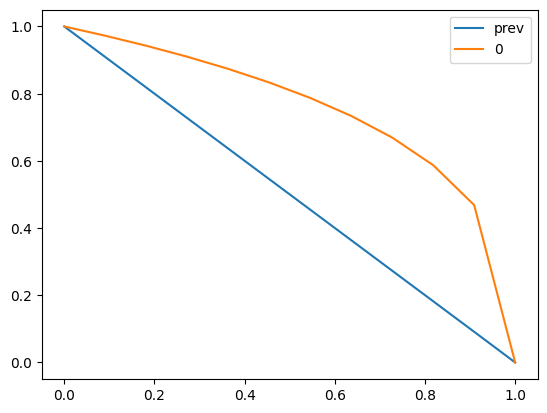

In [46]:
xi = np.linspace(0,1,N+2)
# u0 = np.sqrt(1 - xi)

u1 = np.ones(1)
u1 = np.append(u1, W)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
print(u1)

plt.plot(xi,u1, label = 'prev')
plt.plot(xi,u0, label = '0')
plt.legend()
# plt.figure()
# plt.plot(dW)

In [45]:
W

array([0.90913281, 0.8182656 , 0.72739835, 0.63653104, 0.54566363,
       0.45479604, 0.36392808, 0.27305918, 0.18218732, 0.09129965])

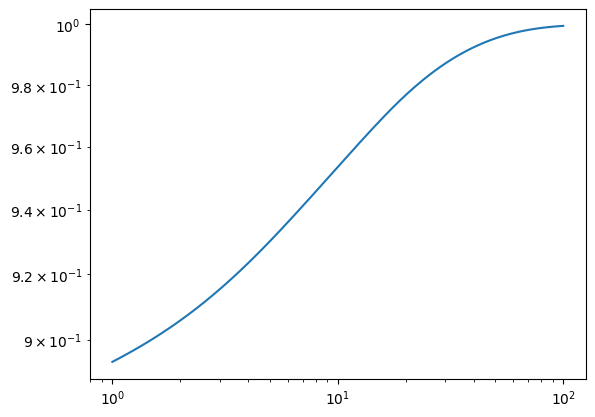

In [55]:
plt.plot(ts[100:], gs[100:])
plt.xscale('log')
plt.yscale('log')

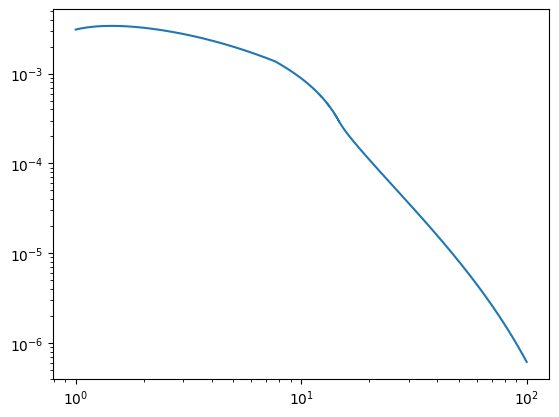

In [56]:
plt.plot(ts[100:], psis[100:])
plt.xscale('log')
plt.yscale('log')

In [42]:
gs

[0.86998,
 2.3086255886057248,
 3.744358250289581,
 5.206871203049939,
 6.701687350206148,
 8.228209408748508,
 9.78492435545651,
 11.370238864131888,
 12.982647184536587,
 14.620762712241744,
 16.28331572195886,
 17.969142463044694,
 19.67717295287135,
 21.406419693450037,
 23.155967869318008,
 24.924967020260006,
 26.712624006092586,
 28.51819704577396,
 30.340990628661466,
 32.180351127018426,
 34.035662972232764,
 35.90634528735567,
 37.79184889374027,
 39.691653629556086,
 41.6052659332628,
 43.53221665650799,
 45.47205907916781,
 47.42436710511835,
 49.38873362143126,
 51.36476900653023,
 53.352099774823955,
 55.350367346706236,
 57.35922693382202,
 59.37834653025009,
 61.407406000871035,
 63.44609625871476,
 65.49411852356835,
 67.55118365458516,
 69.61701155008558,
 71.69133060818149,
 73.77387724229379,
 75.8643954460644,
 77.96263640257477,
 80.06835813320043,
 82.181325181814,
 84.30130833042726,
 86.428084342717,
 88.56143573221323,
 90.70115055224106,
 92.84702220500404,
 

In [19]:
np.diag([1,1], -1)

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [14]:
len(gs)

21